# Tomato Spotted Wilt Virus

## Description
The Tomato Spotted Wilt Virus data comes from an experimental greenhouse epidemic conducted by Hughes et. al. This data was processed and made available through the EpiILM R package.

The experiment consisted of 520 individual tomato uniformly spaced in a 10 x 26m greenhouse. Every 2 weeks it was determined if an individual plant was infected or not. Our analysis follows from day 42 onward.

## Data references
Hughes, G., McRoberts, N., Madden, L.V., Nelson, S.C., 1997. Validating math-ematical models of plant-disease progress in space and time.  MathematicalMedicine and Biology:  A Journal of the IMA 14, 85–112.

Warriyar K.V., V., Deardon, R., 2018. EpiILM: Spatial and Network Based Individual Level Models for Epidemics. URL: https://CRAN.R-project.org/package=EpiILM. R package version 1.4.2.

In [10]:
using CSV, DelimitedFiles, Distances, Random, Pathogen, Plots
Random.seed!(5432)

# POPULATION INFOFORMATION
# Use CSV.jl for DataFrames I/O
# We know the types of the columns, so we'll manually specify those.
# * Individual IDs are `Int64`
# * X,Y coordinates are `Float64`s
risks = CSV.read(joinpath(@__DIR__, "plant_locations.csv"), types=[Int64; Float64; Float64])

# Will precalculate distances
distances = [euclidean([risks[i, :x]; risks[i, :y]], [risks[j, :x]; risks[j, :y]]) for i = 1:size(risks, 1), j = 1:size(risks, 1)]

pop = Population(risks, distances)

Population object (n=520)

In [6]:
# OBSERVATIONS
# Use julia's included CSV interface for simple vector of observation times
raw_observations = readdlm(joinpath(@__DIR__, "infection_observations.csv"))[:]

# Create an `EventObservations` object with `Pathogen.jl`
obs = EventObservations{SI}(raw_observations)

# For performing inference we are going to set everything at or before t = 42 as being the starting state.
starting_states = [obs.infection[i] <= 42.0 ? State_I : State_S for i=1:obs.individuals]

# We will also set these observation times to -Inf
obs.infection[obs.infection .<= 42.0] .= -Inf

obs

SI model observations (n=520)

In [7]:
# RISK FUNCTIONS
function _zero(params::Vector{Float64}, pop::Pathogen.Population, i::Int64)
  return 0.0
end

function _one(params::Vector{Float64}, pop::Pathogen.Population, i::Int64)
  return 1.0
end

function _powerlaw(params::Vector{Float64}, pop::Pathogen.Population, i::Int64, k::Int64)
  α = params[1]
  β = params[2]
  d = pop.distances[k, i]
  return α * (d^(-β))
end

rf = RiskFunctions{SI}(_zero, # sparks function - we will assume no exogenous transmissions and set this to zero
                       _one, # susceptibility function - we do not have individual level risk factor information to explore here, so will set to a constant 1
                       _powerlaw, # transmissability function - we will use a powerlaw (with intercept) kernel. This provides a spatial and non-spatial component to infection transmissions. This has 3 parameters.
                       _one) # infectivity function - we do not have individual level risk factor information to explore here, so will set to a constant 1

SI model risk functions

In [12]:
rpriors = RiskPriors{SI}(UnivariateDistribution[], # empty `UnivariateDistribution` vector for all parameter-less functions
                         UnivariateDistribution[],
                         [Gamma(1.0, 0.5); Gamma(1.0, 1.0)], # Relatively uninformative priors with appropriate support
                         UnivariateDistribution[])

ee = EventExtents{SI}(14.0)

mcmc = MCMC(obs, ee, pop, starting_states, rf, rpriors)
start!(mcmc, attempts = 50000)
iterate!(mcmc, 50000, 1.0, event_batches = 20)

Initialization progress100%|████████████████████████████| Time: 0:09:20
MCMC progress100%|██████████████████████████████████████| Time: 17:04:3851


SI model MCMC with 1 chains

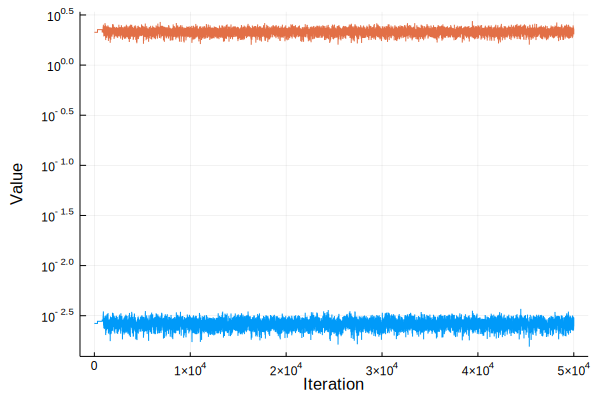

In [19]:
plot(mcmc.markov_chains[1].risk_parameters, yscale=:log10)

In [20]:
summary(mcmc, burnin=10000, thin=10)

,parameter,mean,var,credible99,credible95
,String,Float64,Float64,Tuple…,Tuple…
1,κ₁,0.00262417,5.97215e-8,"(0.0019571, 0.00327122)","(0.00215515, 0.00310494)"
2,κ₂,2.1444,0.0179146,"(1.77181, 2.48953)","(1.87765, 2.39904)"


In [ ]:
tnd = TNDistribution(10000:10:50000, mcmc)

In [ ]:
plot(tnd, pop)

In [ ]:
tracedata = convert(Array{Float64, 2}, mcmc.markov_chains[i].risk_parameters)
events_trace = convert(Array{Float64, 2}, mcmc.markov_chains[i].events)
events_mean = convert(Vector{Float64}, mean(mcmc.markov_chains[i].events))

  writedlm(joinpath(@__DIR__, "output/network_mean_mcmc-$i.csv"), network_mean)
  writedlm(joinpath(@__DIR__, "output/parameter_trace_mcmc-$i.csv"), tracedata)
  writedlm(joinpath(@__DIR__, "output/events_trace_mcmc-$i.csv"), events_trace)
  writedlm(joinpath(@__DIR__, "output/events_mean_mcmc-$i.csv"), events_mean)
